In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ========== Load Dataset ==========
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"  # Update folder & filename if different
df = pd.read_csv(file_path)

# ========== Stratified Split (80% Train, 20% Test) ==========
train_df, test_df = train_test_split(df, test_size=0.20, stratify=df["Binary_class"], random_state=42)

# ========== Save Split Data (Kaggle uses `/kaggle/working` for output) ==========
train_df.to_csv("/kaggle/working/train_data.csv", index=False)
test_df.to_csv("/kaggle/working/test_data.csv", index=False)

# ========== Summary Table ==========
split_summary = pd.DataFrame({
    "Train (80%)": train_df["Binary_class"].value_counts(),
    "Test (20%)": test_df["Binary_class"].value_counts(),
    "Total": df["Binary_class"].value_counts()
}).T

# ========== Save Summary Table ==========
split_summary.to_csv("/kaggle/working/split_summary.csv")

# ========== Display ==========
print("\nData Split Summary:\n", split_summary)
print("\n✅ 80-20 Train-Test split completed and saved to `/kaggle/working/`.")



Data Split Summary:
 Binary_class  Non-Damage  Damage
Train (80%)        12403    2062
Test (20%)          3102     515
Total              15505    2577

✅ 80-20 Train-Test split completed and saved to `/kaggle/working/`.


Extracting embeddings and morphological features...


/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Before SMOTE - Train: [12403  2062]
After SMOTE - Train: [12403 12403]
Before SMOTE - Test: [3102  515]
After SMOTE - Test: [3102 3102]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745933991.470572     200 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/10


I0000 00:00:1745933995.333330     255 service.cc:148] XLA service 0x7888480015c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745933995.333784     255 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745933995.653907     255 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745933997.224541     255 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


776/776 - 7s - 9ms/step - accuracy: 0.6889 - loss: 0.6171
Epoch 2/10
776/776 - 1s - 1ms/step - accuracy: 0.7423 - loss: 0.5217
Epoch 3/10
776/776 - 1s - 1ms/step - accuracy: 0.7686 - loss: 0.4868
Epoch 4/10
776/776 - 1s - 1ms/step - accuracy: 0.7825 - loss: 0.4629
Epoch 5/10
776/776 - 1s - 1ms/step - accuracy: 0.7978 - loss: 0.4409
Epoch 6/10
776/776 - 1s - 1ms/step - accuracy: 0.8117 - loss: 0.4152
Epoch 7/10
776/776 - 1s - 1ms/step - accuracy: 0.8162 - loss: 0.4060
Epoch 8/10
776/776 - 1s - 1ms/step - accuracy: 0.8277 - loss: 0.3835
Epoch 9/10
776/776 - 1s - 1ms/step - accuracy: 0.8333 - loss: 0.3756
Epoch 10/10
776/776 - 1s - 1ms/step - accuracy: 0.8417 - loss: 0.3555
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

📊 Test Evaluation Summary:
✅ Test Accuracy   : 0.7652
✅ Test ROC-AUC    : 0.8402
✅ Classification Report:
               precision    recall  f1-score   support

  Non-Damage       0.73      0.84      0.78      3102
      Damage       0.82      0.69      0.74      3102

    acc

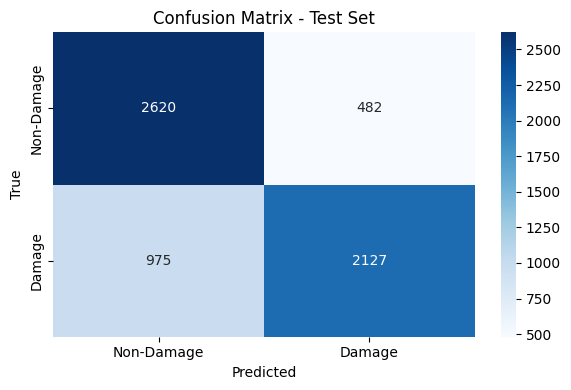

In [3]:
# ====================== Imports ======================
import pandas as pd
import numpy as np
import spacy
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# ====================== Load spaCy model ======================
nlp = spacy.load("en_core_web_sm")

# ====================== Load Data ======================
train_df = pd.read_csv("/kaggle/working/train_data.csv")
test_df = pd.read_csv("/kaggle/working/test_data.csv")

# ====================== Preprocess Labels ======================
label_map = {'damage': 1, 'non-damage': 0}
for df in [train_df, test_df]:
    df['Binary_class'] = df['Binary_class'].str.strip().str.lower().map(label_map)
    df['Processed_data'] = df['Processed_data'].fillna("")

# ====================== ELAMO Feature Extraction ======================
def get_spacy_embeddings(texts, fallback_dim=96):
    vectors = []
    for doc in nlp.pipe(texts, disable=["parser", "ner", "tagger"]):
        vec = doc.vector
        if vec is not None and vec.shape[0] > 0:
            vectors.append(vec)
        else:
            vectors.append(np.zeros(fallback_dim))
    return np.vstack(vectors)

def extract_morphological_features(texts):
    pos_tags = []
    lemmas = []
    for doc in nlp.pipe(texts, disable=["parser", "ner"]):
        pos_tags.append([token.pos_ for token in doc])
        lemmas.append([token.lemma_ for token in doc])
    return pos_tags, lemmas

def combine_elamo_features(X_embed, pos_tags, lemmas):
    pos_diversity = np.array([[len(set(tags))] for tags in pos_tags])
    lemma_diversity = np.array([[len(set(l))] for l in lemmas])
    return np.hstack((X_embed, pos_diversity, lemma_diversity))

# ====================== Extract Features ======================
print("Extracting embeddings and morphological features...")
X_train_embed = get_spacy_embeddings(train_df['Processed_data'])
X_test_embed = get_spacy_embeddings(test_df['Processed_data'])

train_pos_tags, train_lemmas = extract_morphological_features(train_df['Processed_data'])
test_pos_tags, test_lemmas = extract_morphological_features(test_df['Processed_data'])

X_train = combine_elamo_features(X_train_embed, train_pos_tags, train_lemmas)
X_test = combine_elamo_features(X_test_embed, test_pos_tags, test_lemmas)

y_train = train_df['Binary_class'].values
y_test = test_df['Binary_class'].values

# ====================== Apply SMOTE to Train and Test ======================
print("Before SMOTE - Train:", np.bincount(y_train))
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("After SMOTE - Train:", np.bincount(y_train_smote))

print("Before SMOTE - Test:", np.bincount(y_test))
X_test_smote, y_test_smote = smote.fit_resample(X_test, y_test)
print("After SMOTE - Test:", np.bincount(y_test_smote))

# ====================== CNN Model ======================
input_dim = X_train_smote.shape[1]
model = Sequential([
    Dense(512, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ====================== Train the Model ======================
history = model.fit(
    X_train_smote, y_train_smote,
    epochs=10,
    batch_size=32,
    verbose=2
)

# ====================== Evaluate on Test Set ======================
test_loss, test_accuracy = model.evaluate(X_test_smote, y_test_smote, verbose=0)
test_proba = model.predict(X_test_smote).ravel()
test_preds = (test_proba > 0.5).astype(int)
roc_auc = roc_auc_score(y_test_smote, test_proba)

print("\n📊 Test Evaluation Summary:")
print(f"✅ Test Accuracy   : {test_accuracy:.4f}")
print(f"✅ Test ROC-AUC    : {roc_auc:.4f}")
print("✅ Classification Report:\n", classification_report(y_test_smote, test_preds, target_names=['Non-Damage', 'Damage']))

# ====================== Confusion Matrix ======================
cm = confusion_matrix(y_test_smote, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Damage', 'Damage'],
            yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()
